# This jupyter notebook translate VERT_FSFB.m by Youran Li
## and tested it with a sample $N^2$ profile in the California coastal region

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('./MARA_RUN2_SWOT_state_2015-01-06.nc')
#state_ds

In [4]:
state_ds.Depth[130, 100].data

array(4615.188, dtype=float32)

In [5]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [6]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [7]:
temp = state_ds.THETA
salinity = state_ds.SALT
pres  = state_ds.PHIHYD

In [8]:
Z = state_ds.Z
#gsw.stability.Nsquared?

# Calculate Brunt-Vaisla frequency squared

In [9]:
SA, CT, = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

/Users/yugao/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/gsw/stability.py:85: RuntimeWarning: divide by zero encountered in true_divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))
/Users/yugao/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/gsw/stability.py:86: RuntimeWarning: invalid value encountered in multiply
  N2 *= (beta_mid*dSA - alpha_mid*dCT)


In [10]:
Nsquared.shape

(89, 576, 672)

In [11]:
xlon, ylat = np.meshgrid(LON, LAT)

In [12]:
zz, yy = np.meshgrid(Z[1:], LAT)

# Choose a vector at a random location

In [13]:
laty, lonx = 100, 120

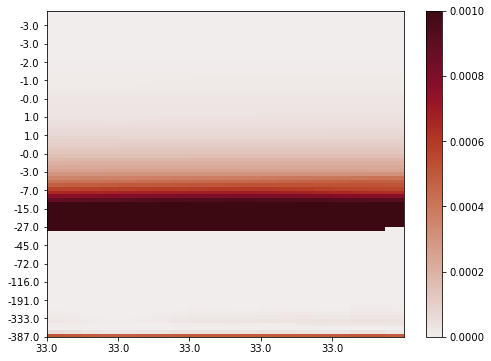

In [14]:
plt.figure(figsize = (8, 6))
latitude_y = LAT[laty:laty+20]
plt.pcolor(Nsquared[:, laty:laty+20, lonx],cmap = cmo.cm.amp, vmin = 0, vmax = 1e-3)
plt.yticks(range(0, 89, 5), np.around(np.flip(Z_mid[0::5, laty, lonx])))
plt.xticks(range(0,20,4), np.around(latitude_y[0::4]))
plt.colorbar()

In [15]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]

# Show where the location is on the map

Text(0.5, 1.0, 'Depth = 0.0')

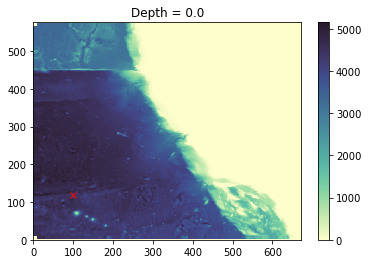

In [16]:
plt.pcolormesh(state_ds.Depth, cmap = cmo.cm.deep)
plt.plot(laty, lonx, 'x', color = 'red')
plt.colorbar()
plt.title('Depth = '+ str(state_ds.Depth[y, x].data))

## Interpolate the N2 vector onto a uniform pressure grid

In [17]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 6)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector, N2_vector)

In [18]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
Pmid_uniform.shape, N2_uniform.shape

((67,), (67,))

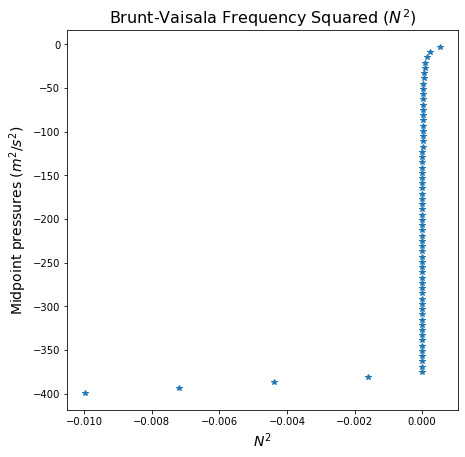

In [19]:
plt.figure(figsize = (7, 7))
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot( N2_uniform, -1 * Pmid_uniform[:], '*')
plt.ylabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.xlabel('$N^2$', fontsize = 14)
#plt.xlim([10, 350])
#plt.ylim([0, 0.0002])
plt.savefig('sample_N2_profile.png')

# TEST FUNCTION

In [20]:
def INTEGRATOR(M, Dz): 
    
    #    Generates and integration matrix.
    #    Integrates from first point to each point.
    
    INT = np.tril(np.ones(M))
    INT = INT - 0.5 * (np.eye(M))
    INT[:,0] = INT[:,0] - 0.5
    INT = INT * Dz
    
    return INT

In [50]:
def  VERT_FSFB3(N2_uniform, Pmid_uniform):
    
    
    '''
    This function removes the barotropic mode.
    '''
    import numpy as np
    import scipy
    import gsw
    from numpy import linalg as LA
    
    for i in range(len(N2_uniform)):
        if N2_uniform[i] < 0:
            N2_uniform[i] = np.min(np.absolute(N2_uniform))
    
    Dz = np.median(np.diff(Pmid_uniform))
    Dzrng = np.max(np.diff(Pmid_uniform)) - np.min(np.diff(Pmid_uniform))
    
    if(Dzrng > 1e-3 * Dz):
        print('Dz is not constant!!')
    # else: print('Dz is constant.')
    
    # add a point for the surface
    # note that this means that Psi has one more depth than N2!!
    M = len(N2_uniform) + 1
    #  Fill in D - the differential operator matrix.
    #  Surface (repeat N2 from midpoint depth)
    D = np.zeros([M, M]) # Make a M x M zero array
    
    D[0, 0] = -2/N2_uniform[0]
    D[0, 1] = 2/N2_uniform[0]

    # Interior
    for i in range(1, M-1):
        D[i, i-1] = 1/N2_uniform[i-1]
        D[i, i] = -1/N2_uniform[i-1] - 1/N2_uniform[i]
        D[i, i+1] = 1/N2_uniform[i]

    # Bottom
    #D[M-1, M-2] = 1/N2_uniform[M-2]
    D[M-1, M-2] = 2/N2_uniform[M-2]
    D[M-1, M-1]  = -2/N2_uniform[M-2]
    D = -1 * D / (Dz * Dz)
    
    # BDC: D should be a tridiagonal matrix
    # Calculate generalized eigenvalue problem
    Lambda, Psi = LA.eig(D)
    # LA.eig() Compute the eigenvalues and right eigenvectors of a square array.
    # Lambda:    The eigenvalues, each repeated according to its multiplicity.
    # Psi: The normalized (unit "length") eigenvectors, such that the 
    # column ``Psi[:,i]`` is the eigenvector corresponding to the eigenvalue Lambda[i].
    
    # Remove Barotropic Mode 
    # lambda = 1/(radius of deformation * f)^2 (m/s)^{-2}
    # BT mode, rd = infinity. hence lambda = 0.
    ind = np.where(Lambda >= 1e-11)
    print(len(ind[0]))
    Lambda = Lambda[ind]
    Psi = Psi[:, ind].reshape([D.shape[0], len(ind[0])])
    print(Psi[:].shape)
    
    # Sort eigenvalues and eigenvectors
    idx = np.argsort(Lambda)
    Lambda_sorted = Lambda[idx]
    Psi_sorted = Psi[:,idx]
    c2 = 1 / Lambda_sorted # Modal Speed
    #print(Psi_sorted[:].shape)
    
    # reference to top value
    for i in range(Psi_sorted.shape[1]):
        Psi_sorted[:, i] = Psi_sorted[:, i] / Psi_sorted[0, i]
    
    INT = INTEGRATOR(M, Dz)
    G = np.matmul(INT, Psi_sorted)

    return c2, Psi, G, N2_uniform, Pmid_uniform 

In [51]:
N2_uniform.shape, Pmid_uniform.shape

((67,), (67,))

In [52]:
c2, Psi, G, N2, Pmid = VERT_FSFB3(N2_uniform, Pmid_uniform)

67
(68, 67)


In [53]:
g = 9.8 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [54]:
SSH = G/g
SSH.shape

(68, 67)

In [55]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)
Z_mid_uniform.shape, N2.shape

((68,), (67,))

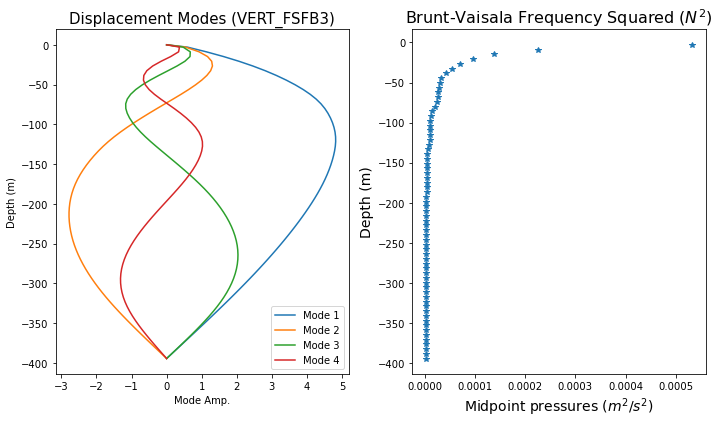

In [63]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.legend()
plt.title('Displacement Modes (VERT_FSFB3)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
#plt.ylim([0, 0.0002])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS.png')

In [64]:
MODE = G.shape[-1]

In [65]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

In [66]:
mode.shape, Zgrid.shape, SSH[:].shape

((67, 68), (67, 68), (68, 67))

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_34584/3790807359.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_34584/3790807359.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_34584/3790807359.py:25: Matplotlib

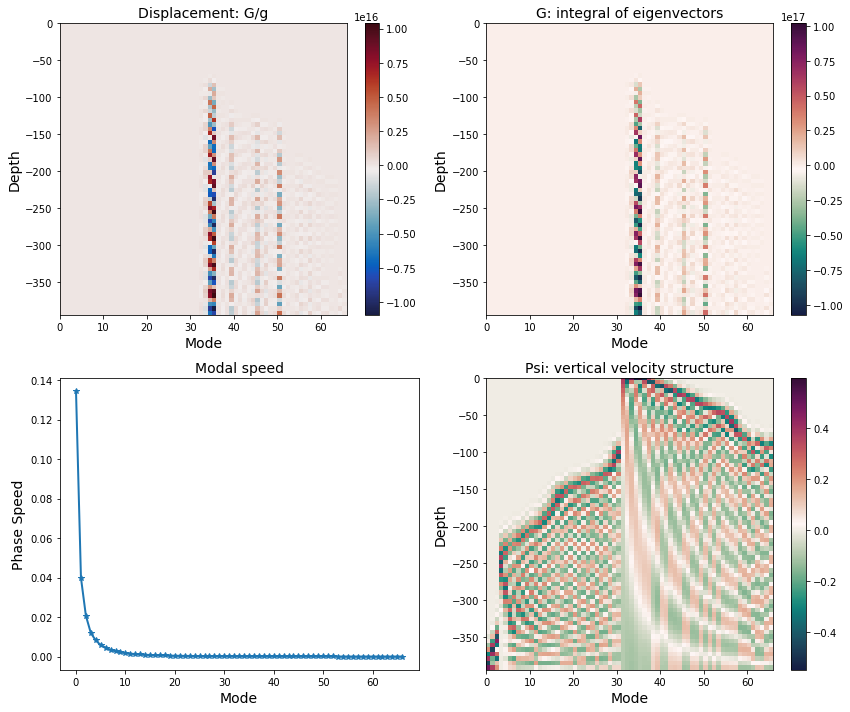

In [67]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Phase Speed', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: vertical velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample.png', dpi = 100)